## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import tensorflow.keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
train, test = tensorflow.keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tensorflow.keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = tensorflow.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = tensorflow.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tensorflow.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer_set = [tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 tensorflow.keras.optimizers.Adam(lr=LEARNING_RATE),
                 tensorflow.keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.5,0.7]
redice_lr_patient = [3,5,7]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
bat

50000/50000 [==============================] - 4s 85us/sample - loss: 1.5364 - accuracy: 0.4638 - val_loss: 1.6353 - val_accuracy: 0.4221
Epoch 10/25
50000/50000 [==============================] - 4s 80us/sample - loss: 1.5110 - accuracy: 0.4727 - val_loss: 1.6135 - val_accuracy: 0.4364
Epoch 11/25
50000/50000 [==============================] - 4s 81us/sample - loss: 1.4892 - accuracy: 0.4804 - val_loss: 1.6006 - val_accuracy: 0.4398
Epoch 12/25
50000/50000 [==============================] - 4s 81us/sample - loss: 1.4678 - accuracy: 0.4888 - val_loss: 1.5907 - val_accuracy: 0.4428
Epoch 13/25
50000/50000 [==============================] - 4s 81us/sample - loss: 1.4490 - accuracy: 0.4937 - val_loss: 1.5859 - val_accuracy: 0.4465
Epoch 14/25
50000/50000 [==============================] - 4s 80us/sample - loss: 1.4309 - accuracy: 0.5014 - val_loss: 1.5757 - val_accuracy: 0.4489
Epoch 15/25
50000/50000 [==============================] - 4s 82us/sample - loss: 1.4159 - accuracy: 0.5059 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 109us/sample - loss: 2.5121 - accuracy: 0.2062 - val_loss: 2.1882 - val_accuracy: 0.1849
Epoch 2/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.9837 - accuracy: 0.3268 - val_loss: 2.0581 - val_accuracy: 0.2580
Epoch 3/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.8281 - accuracy: 0.3692 - val_loss: 1.9469 - val_accuracy: 0.3106
Epoch 4/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.7434 - accuracy: 0.3947 - val_loss: 1.8694 - val_accuracy: 0.3427
Epoch 5/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.6871 - accuracy: 0.4135 - val_loss: 1.7858 - val_accuracy: 0.3695
Epoch 6/25
50000/50000 [==============================] - 4s 88us/sample - loss: 1.6417 - accuracy: 0.4285 - val_loss: 1.7266 - val_accuracy: 0.3878
Epoch 7/25
50000/50000 [==============================]

50000/50000 [==============================] - 5s 93us/sample - loss: 1.3470 - accuracy: 0.5296 - val_loss: 1.5432 - val_accuracy: 0.4612
Epoch 21/25
50000/50000 [==============================] - 5s 93us/sample - loss: 1.3329 - accuracy: 0.5357 - val_loss: 1.5390 - val_accuracy: 0.4631
Epoch 22/25
50000/50000 [==============================] - 5s 91us/sample - loss: 1.3212 - accuracy: 0.5388 - val_loss: 1.5376 - val_accuracy: 0.4620
Epoch 23/25
50000/50000 [==============================] - 5s 90us/sample - loss: 1.3082 - accuracy: 0.5452 - val_loss: 1.5308 - val_accuracy: 0.4661
Epoch 24/25
50000/50000 [==============================] - 5s 92us/sample - loss: 1.2966 - accuracy: 0.5498 - val_loss: 1.5268 - val_accuracy: 0.4652
Epoch 25/25
50000/50000 [==============================] - 5s 90us/sample - loss: 1.2857 - accuracy: 0.5534 - val_loss: 1.5240 - val_accuracy: 0.4686
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 7
Model: "model_5"
_____________________________________

50000/50000 [==============================] - 5s 95us/sample - loss: 1.7549 - accuracy: 0.3888 - val_loss: 1.8507 - val_accuracy: 0.3520
Epoch 5/25
50000/50000 [==============================] - 5s 93us/sample - loss: 1.6978 - accuracy: 0.4080 - val_loss: 1.7808 - val_accuracy: 0.3736
Epoch 6/25
50000/50000 [==============================] - 5s 91us/sample - loss: 1.6498 - accuracy: 0.4247 - val_loss: 1.7298 - val_accuracy: 0.3912
Epoch 7/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.6130 - accuracy: 0.4367 - val_loss: 1.6968 - val_accuracy: 0.4039
Epoch 8/25
50000/50000 [==============================] - 4s 90us/sample - loss: 1.5800 - accuracy: 0.4480 - val_loss: 1.6599 - val_accuracy: 0.4151
Epoch 9/25
50000/50000 [==============================] - 5s 91us/sample - loss: 1.5515 - accuracy: 0.4602 - val_loss: 1.6421 - val_accuracy: 0.4236
Epoch 10/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.5256 - accuracy: 0.4681 - val_los

50000/50000 [==============================] - 5s 91us/sample - loss: 1.3076 - accuracy: 0.5479 - val_loss: 1.5512 - val_accuracy: 0.4614
Epoch 24/25
50000/50000 [==============================] - 5s 91us/sample - loss: 1.2964 - accuracy: 0.5503 - val_loss: 1.5481 - val_accuracy: 0.4613
Epoch 25/25
50000/50000 [==============================] - 5s 90us/sample - loss: 1.2834 - accuracy: 0.5561 - val_loss: 1.5421 - val_accuracy: 0.4630
Numbers of exp: 8, reduce_factor: 0.70, reduce_patient: 7
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________

49152/50000 [============================>.] - ETA: 0s - loss: 1.1489 - accuracy: 0.5956
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
50000/50000 [==============================] - 5s 91us/sample - loss: 1.1498 - accuracy: 0.5953 - val_loss: 1.9321 - val_accuracy: 0.3588
Epoch 8/25
50000/50000 [==============================] - 5s 90us/sample - loss: 1.0377 - accuracy: 0.6416 - val_loss: 1.5800 - val_accuracy: 0.4512
Epoch 9/25
50000/50000 [==============================] - 5s 91us/sample - loss: 0.9837 - accuracy: 0.6632 - val_loss: 1.6038 - val_accuracy: 0.4539
Epoch 10/25
50000/50000 [==============================] - 4s 90us/sample - loss: 0.9527 - accuracy: 0.6735 - val_loss: 1.4829 - val_accuracy: 0.4810
Epoch 11/25
50000/50000 [==============================] - 5s 93us/sample - loss: 0.9169 - accuracy: 0.6861 - val_loss: 1.4704 - val_accuracy: 0.4976
Epoch 12/25
50000/50000 [==============================] - 5s 90us/sample - loss: 0.8892 - accu

50000/50000 [==============================] - 4s 88us/sample - loss: 1.3592 - accuracy: 0.5314 - val_loss: 1.5716 - val_accuracy: 0.4551
Epoch 23/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.3497 - accuracy: 0.5341 - val_loss: 1.5679 - val_accuracy: 0.4552
Epoch 24/25
50000/50000 [==============================] - 4s 88us/sample - loss: 1.3401 - accuracy: 0.5383 - val_loss: 1.5653 - val_accuracy: 0.4522
Epoch 25/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.3313 - accuracy: 0.5404 - val_loss: 1.5610 - val_accuracy: 0.4603
Numbers of exp: 11, reduce_factor: 0.30, reduce_patient: 7
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_____

50000/50000 [==============================] - 5s 94us/sample - loss: 1.5794 - accuracy: 0.4525 - val_loss: 1.6840 - val_accuracy: 0.4086
Epoch 7/25
50000/50000 [==============================] - 5s 95us/sample - loss: 1.5511 - accuracy: 0.4632 - val_loss: 1.6568 - val_accuracy: 0.4178
Epoch 8/25
50000/50000 [==============================] - 5s 94us/sample - loss: 1.5281 - accuracy: 0.4699 - val_loss: 1.6375 - val_accuracy: 0.4195
Epoch 9/25
50000/50000 [==============================] - 5s 95us/sample - loss: 1.5068 - accuracy: 0.4782 - val_loss: 1.6236 - val_accuracy: 0.4268
Epoch 10/25
50000/50000 [==============================] - 5s 94us/sample - loss: 1.4874 - accuracy: 0.4847 - val_loss: 1.6102 - val_accuracy: 0.4303
Epoch 11/25
50000/50000 [==============================] - 5s 94us/sample - loss: 1.4699 - accuracy: 0.4917 - val_loss: 1.6030 - val_accuracy: 0.4318
Epoch 12/25
50000/50000 [==============================] - 5s 95us/sample - loss: 1.4555 - accuracy: 0.4964 - val_l

50000/50000 [==============================] - 5s 95us/sample - loss: 1.3003 - accuracy: 0.5508 - val_loss: 1.5420 - val_accuracy: 0.4573
Numbers of exp: 14, reduce_factor: 0.50, reduce_patient: 7
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_42 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
___________________________________________________________

50000/50000 [==============================] - 4s 90us/sample - loss: 1.5092 - accuracy: 0.4751 - val_loss: 1.6239 - val_accuracy: 0.4325
Epoch 10/25
50000/50000 [==============================] - 4s 90us/sample - loss: 1.4888 - accuracy: 0.4822 - val_loss: 1.6133 - val_accuracy: 0.4343
Epoch 11/25
50000/50000 [==============================] - 4s 90us/sample - loss: 1.4718 - accuracy: 0.4875 - val_loss: 1.6074 - val_accuracy: 0.4391
Epoch 12/25
50000/50000 [==============================] - 5s 91us/sample - loss: 1.4560 - accuracy: 0.4933 - val_loss: 1.5964 - val_accuracy: 0.4435
Epoch 13/25
50000/50000 [==============================] - 4s 89us/sample - loss: 1.4416 - accuracy: 0.4987 - val_loss: 1.5921 - val_accuracy: 0.4415
Epoch 14/25
50000/50000 [==============================] - 5s 91us/sample - loss: 1.4274 - accuracy: 0.5026 - val_loss: 1.5858 - val_accuracy: 0.4461
Epoch 15/25
50000/50000 [==============================] - 4s 90us/sample - loss: 1.4151 - accuracy: 0.5086 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 110us/sample - loss: 2.1778 - accuracy: 0.2806 - val_loss: 2.1338 - val_accuracy: 0.2361
Epoch 2/25
50000/50000 [==============================] - 4s 90us/sample - loss: 1.8132 - accuracy: 0.3739 - val_loss: 2.0042 - val_accuracy: 0.2903
Epoch 3/25
50000/50000 [==============================] - 4s 90us/sample - loss: 1.7141 - accuracy: 0.4033 - val_loss: 1.8848 - val_accuracy: 0.3472
Epoch 4/25
50000/50000 [==============================] - 4s 90us/sample - loss: 1.6549 - accuracy: 0.4234 - val_loss: 1.7944 - val_accuracy: 0.3733
Epoch 5/25
50000/50000 [==============================] - 5s 90us/sample - loss: 1.6124 - accuracy: 0.4387 - val_loss: 1.7280 - val_accuracy: 0.3917
Epoch 6/25
50000/50000 [==============================] - 5s 92us/sample - loss: 1.5780 - accuracy: 0.4501 - val_loss: 1.6768 - val_accuracy: 0.4100
Epoch 7/25
50000/50000 [==============================]

Epoch 18/25
50000/50000 [==============================] - 5s 96us/sample - loss: 0.7769 - accuracy: 0.7434 - val_loss: 1.3390 - val_accuracy: 0.5359
Epoch 19/25
49152/50000 [============================>.] - ETA: 0s - loss: 0.7676 - accuracy: 0.7457
Epoch 00019: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
50000/50000 [==============================] - 5s 96us/sample - loss: 0.7670 - accuracy: 0.7457 - val_loss: 1.3321 - val_accuracy: 0.5438
Epoch 20/25
50000/50000 [==============================] - 5s 102us/sample - loss: 0.7462 - accuracy: 0.7556 - val_loss: 1.3235 - val_accuracy: 0.5439
Epoch 21/25
50000/50000 [==============================] - 5s 95us/sample - loss: 0.7411 - accuracy: 0.7574 - val_loss: 1.3231 - val_accuracy: 0.5444
Epoch 22/25
49152/50000 [============================>.] - ETA: 0s - loss: 0.7370 - accuracy: 0.7589
Epoch 00022: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
50000/50000 [==============================] - 5s

50000/50000 [==============================] - 6s 126us/sample - loss: 2.8620 - accuracy: 0.1242 - val_loss: 2.2958 - val_accuracy: 0.1283
Epoch 2/25
50000/50000 [==============================] - 5s 91us/sample - loss: 2.6367 - accuracy: 0.1620 - val_loss: 2.2651 - val_accuracy: 0.1577
Epoch 3/25
50000/50000 [==============================] - 4s 89us/sample - loss: 2.4800 - accuracy: 0.1935 - val_loss: 2.2274 - val_accuracy: 0.1837
Epoch 4/25
50000/50000 [==============================] - 4s 89us/sample - loss: 2.3642 - accuracy: 0.2228 - val_loss: 2.1829 - val_accuracy: 0.2108
Epoch 5/25
50000/50000 [==============================] - 4s 89us/sample - loss: 2.2771 - accuracy: 0.2433 - val_loss: 2.1385 - val_accuracy: 0.2385
Epoch 6/25
50000/50000 [==============================] - 5s 91us/sample - loss: 2.2088 - accuracy: 0.2618 - val_loss: 2.0988 - val_accuracy: 0.2611
Epoch 7/25
50000/50000 [==============================] - 5s 99us/sample - loss: 2.1523 - accuracy: 0.2764 - val_los

50000/50000 [==============================] - 5s 103us/sample - loss: 1.8143 - accuracy: 0.3698 - val_loss: 1.8744 - val_accuracy: 0.3553
Epoch 21/25
50000/50000 [==============================] - 5s 99us/sample - loss: 1.7993 - accuracy: 0.3746 - val_loss: 1.8638 - val_accuracy: 0.3605
Epoch 22/25
50000/50000 [==============================] - 5s 98us/sample - loss: 1.7878 - accuracy: 0.3783 - val_loss: 1.8530 - val_accuracy: 0.3623
Epoch 23/25
50000/50000 [==============================] - 5s 97us/sample - loss: 1.7754 - accuracy: 0.3824 - val_loss: 1.8437 - val_accuracy: 0.3665
Epoch 24/25
50000/50000 [==============================] - 5s 97us/sample - loss: 1.7624 - accuracy: 0.3854 - val_loss: 1.8334 - val_accuracy: 0.3685
Epoch 25/25
50000/50000 [==============================] - 5s 95us/sample - loss: 1.7521 - accuracy: 0.3899 - val_loss: 1.8240 - val_accuracy: 0.3703
Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 5
Model: "model_22"
__________________________________

50000/50000 [==============================] - 5s 102us/sample - loss: 2.3378 - accuracy: 0.2282 - val_loss: 2.1593 - val_accuracy: 0.2133
Epoch 5/25
50000/50000 [==============================] - 5s 100us/sample - loss: 2.2576 - accuracy: 0.2478 - val_loss: 2.1119 - val_accuracy: 0.2383
Epoch 6/25
50000/50000 [==============================] - 5s 99us/sample - loss: 2.1935 - accuracy: 0.2663 - val_loss: 2.0760 - val_accuracy: 0.2572
Epoch 7/25
50000/50000 [==============================] - 5s 100us/sample - loss: 2.1400 - accuracy: 0.2784 - val_loss: 2.0474 - val_accuracy: 0.2759
Epoch 8/25
50000/50000 [==============================] - 5s 97us/sample - loss: 2.0930 - accuracy: 0.2915 - val_loss: 2.0279 - val_accuracy: 0.2870
Epoch 9/25
50000/50000 [==============================] - 5s 97us/sample - loss: 2.0534 - accuracy: 0.3026 - val_loss: 2.0109 - val_accuracy: 0.2964
Epoch 10/25
50000/50000 [==============================] - 5s 97us/sample - loss: 2.0193 - accuracy: 0.3120 - val_

50000/50000 [==============================] - 5s 98us/sample - loss: 1.7713 - accuracy: 0.3845 - val_loss: 1.8394 - val_accuracy: 0.3650
Epoch 24/25
50000/50000 [==============================] - 5s 98us/sample - loss: 1.7587 - accuracy: 0.3893 - val_loss: 1.8298 - val_accuracy: 0.3677
Epoch 25/25
50000/50000 [==============================] - 5s 98us/sample - loss: 1.7470 - accuracy: 0.3932 - val_loss: 1.8219 - val_accuracy: 0.3693
Numbers of exp: 25, reduce_factor: 0.70, reduce_patient: 5
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_75 (Batc (None, 512)               2048      
_______________________

KeyboardInterrupt: 

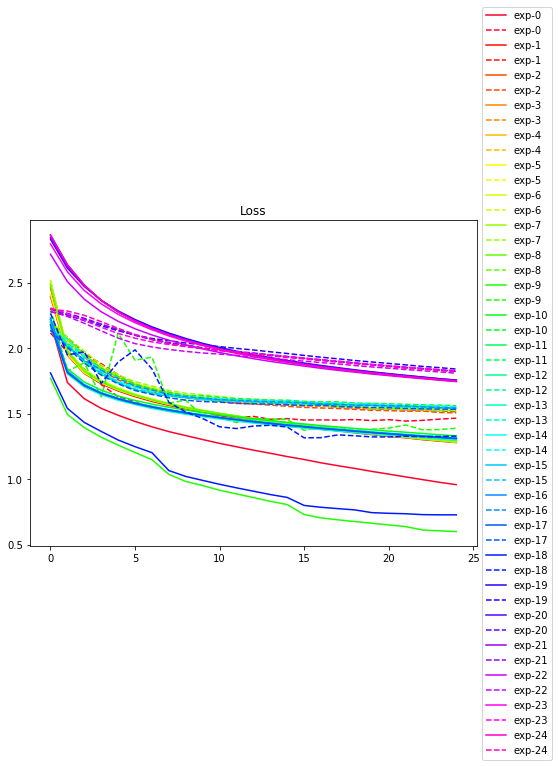

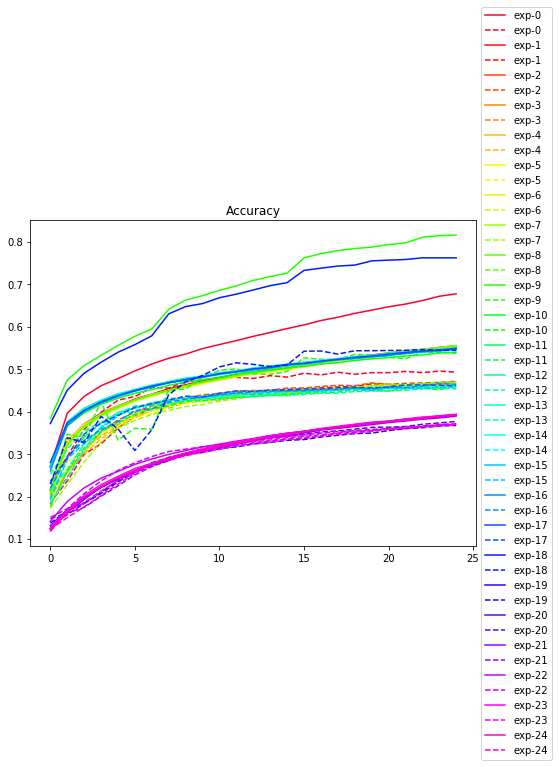

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()